# Measuring the Mass-Ratio Distribution in Real Data
This notebook will eventually contain the code that runs my real data through the pipeline I have developed. For now, I am using it to combined all the literature data with my measurements to make plots for my committee meeting...

In [15]:
import pandas as pd
import HelperFunctions
import numpy as np
import plottools
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
%matplotlib inline

In [2]:
# Read in my companion data
my_companion_data = pd.read_csv('Corrected_Companion_Data.csv', sep='|', index_col=0).drop_duplicates(subset=['Star'])
my_companion_data['q'] = my_companion_data.Mass / my_companion_data.M1
my_companion_data[['Star', 'SpT', 'configuration', 'M1', 'Corrected_Temperature', 'Mass', 'q']].head()

,Star,SpT,configuration,M1,Corrected_Temperature,Mass,q
0,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,2.5,5732.026888,0.999830,0.399932
2,HIP 3478,B5V,B5V,4.6,5524.145146,0.957456,0.208143
3,HIP 5310,A3V,(A3V + ?; ?),2.0,3342.632190,0.352456,0.176228
4,HR 545,B9.5IV,B9V,2.5,4312.193647,0.728463,0.291385
7,HR 604,B8V+A0V,(2.33K3IIb + 5.02(5.5(B7V + B9V; 2.67d) + 6.2A...,3.4,4735.581056,0.794542,0.233689


In [3]:
# Read in my full sample
sample = HelperFunctions.read_observed_targets()[['identifier', 'RA/DEC (J2000)', 'plx', 'Vmag', 'Kmag',
                                                  'vsini', 'SpT', 'configuration']]
sample.head()

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/pandas/core/format.py:2080: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e8).any()
/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/pandas/core/format.py:2081: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) &
/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/pandas/core/format.py:2082: RuntimeWarning: invalid value encountered in greater
  (abs_vals > 0)).any()


,identifier,RA/DEC (J2000),plx,Vmag,Kmag,vsini,SpT,configuration
1,HIP 813,00 10 02.20293 +11 08 44.9280,10.68,5.537,NaN,249,B9Vn,"(5.5B9Vn + 10.0G5Ve; 7.7"")"
2,HIP 1191,00 14 54.51542 -09 34 10.4503,9.63,5.757,5.941,128,B8.5V,B9V
3,HIP 1366,00 17 05.49885 +38 40 53.8902,10.56,4.619,4.416,102,A2V,"(A2V + ?; .06"")"
4,HIP 1647,00 20 39.03682 -69 37 29.6821,10.25,5.498,5.497,236,B9V,"(B9V + K10.1XR; 2.28"")"
5,HIP 2381,00 30 22.65465 -23 47 15.6501,18.83,5.190,4.830,167,A3V,A3V


# Compare my sample to stars in SB9

In [4]:

def check_sb9(starname):
    query_result = Vizier.query_object(starname, catalog='B/sb9/main')
    if len(query_result) == 0:
        return pd.DataFrame(data=dict(star=starname, sb9_binary=False, separation=np.nan, K1=np.nan), index=[0])
    K1 = []
    K2 = []
    for i in range(len(query_result[0])):
        orbit = Vizier.query_constraints(catalog='B/sb9/orbits', Seq=query_result[0]['Seq'][i])[0]
        orbit['K1'].fill_value = np.nan
        orbit['K2'].fill_value = np.nan
        for j in range(len(orbit)):
            K1.append(orbit.filled()['K1'][j])
            K2.append(orbit.filled()['K2'][j])
    N = len(K1)
    binarity = [True]*N
    separation = [np.nan]*N
    return pd.DataFrame(data=dict(star=[starname]*N, wds_binary=binarity, separation=separation, K1=K1, K2=K2), index=range(N))

tmp = sample.drop_duplicates(subset=['identifier']).identifier.map(check_sb9)
sb9_binarity= pd.concat([tmp[i] for i in tmp.index], ignore_index=True)
sb9_binarity['q'] = sb9_binarity.K1 / sb9_binarity.K2
sb9_binarity.head()

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/astroquery/vizier/core.py:567: UserWarning: VOTABLE parsing raised exception: 
  warnings.warn("VOTABLE parsing raised exception: {0}".format(ex))


,K1,K2,sb9_binary,separation,star,wds_binary,q
0,NaN,NaN,False,NaN,HIP 813,NaN,NaN
1,NaN,NaN,False,NaN,HIP 1191,NaN,NaN
2,NaN,NaN,False,NaN,HIP 1366,NaN,NaN
3,NaN,NaN,False,NaN,HIP 1647,NaN,NaN
4,NaN,NaN,False,NaN,HIP 2381,NaN,NaN


In [5]:
# Combine to make a companion data dataframe
sb9 = sb9_binarity.rename(columns=dict(star='Star', K1='SB9_K1', K2='SB9_K2', q='SB9_q')).dropna(subset=['SB9_q'])
for col in ['SB9_K1', 'SB9_K2', 'SB9_q']:
    sb9[col] = pd.to_numeric(sb9[col], errors='raise')
highq = sb9.SB9_q > 1
sb9.loc[highq, 'SB9_q'] = 1.0/sb9.loc[highq, 'SB9_q']
companions = pd.merge(my_companion_data, sb9[['Star', 'SB9_K1', 'SB9_K2', 'SB9_q']], how='outer', on='Star')
companions[['Star', 'SpT', 'configuration', 'M1', 'Corrected_Temperature', 'Mass', 'q', 'SB9_q']].head(10)

,Star,SpT,configuration,M1,Corrected_Temperature,Mass,q,SB9_q
0,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,2.50,5732.026888,0.999830,0.399932,NaN
1,HIP 3478,B5V,B5V,4.60,5524.145146,0.957456,0.208143,NaN
2,HIP 5310,A3V,(A3V + ?; ?),2.00,3342.632190,0.352456,0.176228,NaN
3,HR 545,B9.5IV,B9V,2.50,4312.193647,0.728463,0.291385,NaN
4,HR 604,B8V+A0V,(2.33K3IIb + 5.02(5.5(B7V + B9V; 2.67d) + 6.2A...,3.40,4735.581056,0.794542,0.233689,0.797872
5,HIP 10732,A1Vn,A1Vn,2.20,5577.927970,0.969567,0.440712,NaN
6,HIP 12332,A7V,A7V,1.76,5550.528215,0.966207,0.548981,NaN
7,HIP 12706,A2Vn+F4V,"((3.56A3V + 6.63F3V; 2.600"") + 10.16K5; 840"")",2.10,6050.570384,1.144111,0.544815,NaN
8,HIP 13165,B6V,((5.30(B6V + ?; 3.854d e=.04) + 8.46A0Vp; 3...,4.00,5772.934289,1.000626,0.250157,NaN
9,HIP 13327,B7V,B7V,3.90,5524.330660,0.957542,0.245524,NaN


In [6]:
companions.loc[(companions.q.notnull()) & (companions.SB9_q.notnull())][['Star', 'configuration', 'q', 'SB9_q']]

,Star,configuration,q,SB9_q
4,HR 604,(2.33K3IIb + 5.02(5.5(B7V + B9V; 2.67d) + 6.2A...,0.233689,0.797872
10,HIP 14576,((6.0G8IV + 2.2B8V; 2.87d SD) + 4.72F1; 1.8...,0.434948,0.218905
11,HIP 14576,((6.0G8IV + 2.2B8V; 2.87d SD) + 4.72F1; 1.8...,0.434948,0.379747
15,HIP 16611,(B8V + B8V; 6.224d e=.20),0.333687,0.962617
18,HIP 18724,"((A4IV + B3V; 3.953d SD) + ?; 33.03d, e=0.15)",0.266796,0.266167
42,HIP 76267,(B9.5IV + G2V; 17.36d e=.37),0.421110,0.357576
45,HIP 78820,"(2.59((B0.5V + B; 6.828d e=.29) + 5.9; .5"")...",0.089001,0.632828
46,HIP 78821,"(2.59((B0.5V + B; 6.828d e=.29) + 5.9; .5"")...",0.113295,0.632828


There is a small amount of overlap where both I and SB9 find companions with a measureable q. 

- HIP 14576: There are two companions, I detect the more massive of the two. I will just nanify my companions.
- HR 604: I detect what is likely the K3 companion, which is different than the one given by SB9 so I will keep both
- HIP 16611: These are apparently different companions. For now I am not paying attention to how likely my detections are false positives...
- HIP 18724: Same companion. I will nanify my detection since the dynamical constrant is better
- HIP 76267: Same as above
- HIP 78820, HIP 78821: The SB9 data is for the same companion, while mine is for a different companion? I will nanify one of the SB9 ones and one of mine

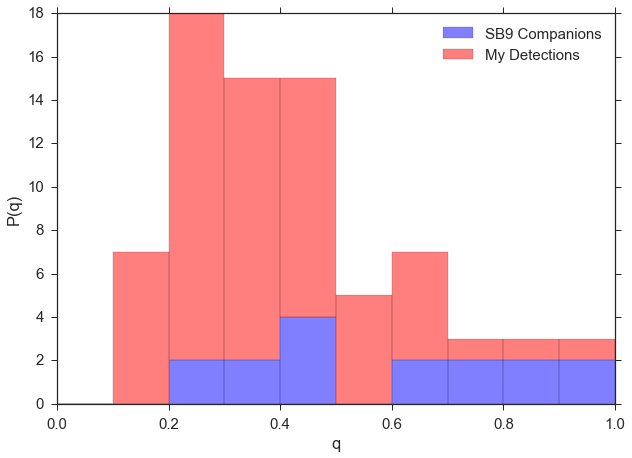

In [7]:
companions.loc[[10, 11, 18, 42, 45], 'q'] = np.nan
companions.loc[45, 'SB9_q'] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(10,7))
bins = np.arange(0, 1.1, 0.1)
low, _, _ = ax.hist(companions.SB9_q.dropna().values, bins=bins, color='blue', alpha=0.5, label='SB9 Companions')
ax.hist(companions.q.dropna().values, bins=bins, bottom=low, color='red', alpha=0.5, label='My Detections')
leg = ax.legend(loc='best', fancybox=True)
ax.set_xlabel('q')
ax.set_ylabel('P(q)')
plt.savefig('Figures/CombinedMassRatios.pdf')
#companions.SB9_q.hist(bins=bins, color='blue', alpha=0.5)

# Add in WDS data
I have compiled a bunch of data from the WDS interferometry (which is really just the WDS but where they give every measurement instead of a summary that leaves out a lot). I will read that in, and use the delta-m measurements to estimate the mass ratio of the systems.

In [8]:
wds = pd.read_excel('/home/kgullikson/Dropbox/School/Research/Databases/Imaging/WDS_Imaging_Data_Checked.xls', 
              sheetname=0)
wds[['star', 'wds_comp', 'epoch', 'mag1', 'mag1_err', 'mag2', 'mag2_err', 'filt_lam', 'filt_fwhm']].head()

,star,wds_comp,epoch,mag1,mag1_err,mag2,mag2_err,filt_lam,filt_fwhm
0,HIP 1366,AB,1986.8969,NaN,NaN,NaN,NaN,549,22
1,HIP 1366,AB,1989.7174,NaN,NaN,NaN,NaN,549,22
2,HIP 1366,AB,1991.8934,NaN,NaN,NaN,NaN,549,22
3,HIP 1366,AB,1991.9016,NaN,NaN,NaN,NaN,508,41
4,HIP 1366,AB,1996.5378,NaN,NaN,NaN,NaN,549,22


In [9]:
wds = pd.merge(sample[['identifier', 'Vmag', 'SpT', 'configuration']], wds, left_on='identifier', right_on='star', how='right')

In [10]:
wds.loc[wds.mag2.notnull(), ['star', 'wds_comp', 'SpT', 'configuration', 'epoch', 'mag1', 'mag1_err', 'mag2', 'mag2_err', 'filt_lam', 'filt_fwhm']]

,star,wds_comp,SpT,configuration,epoch,mag1,mag1_err,mag2,mag2_err,filt_lam,filt_fwhm
6,HIP 1647,AB,B9V,"(B9V + K10.1XR; 2.28"")",1999.200,NaN,NaN,11.700,NaN,1250,380
7,HIP 1647,AB,B9V,"(B9V + K10.1XR; 2.28"")",1999.200,NaN,NaN,10.300,NaN,1620,NaN
8,HIP 1647,AB,B9V,"(B9V + K10.1XR; 2.28"")",1999.200,NaN,NaN,10.100,NaN,2200,480
9,HIP 2381,AB,A3V,A3V,2005.930,NaN,NaN,6.206,0.088,2180,60
10,HIP 2381,AB,A3V,A3V,2007.000,4.830,0.020,11.040,0.090,2150,NaN
11,HIP 2381,AB,A3V,A3V,2007.730,NaN,NaN,6.229,0.055,2180,60
12,HIP 2381,AB,A3V,A3V,2007.736,NaN,NaN,6.230,NaN,2180,60
13,HIP 2381,AB,A3V,A3V,2008.790,NaN,NaN,7.401,0.711,2169,30
143,HIP 2505,AB,B8Vn,"(5.44B7.5Vn + 5.48B8.5V; .446"")",1990.854,NaN,NaN,0.300,NaN,547,24
144,HIP 2505,AB,B8Vn,"(5.44B7.5Vn + 5.48B8.5V; .446"")",1990.854,NaN,NaN,0.300,NaN,547,24


In [19]:
import pysynphot
from astropy import units as u, constants
import SpectralTypeRelations
import Mamajek_Table
from scipy.optimize import minimize_scalar

MS = SpectralTypeRelations.MainSequence()
MT = Mamajek_Table.MamajekTable()
MT.mam_df['radius'] = 10**(0.5*MT.mam_df.logL - 2.0*MT.mam_df.logT + 2.0*3.762)
teff2radius = MT.get_interpolator('Teff', 'radius')

def errfcn(Teff2, Teff1, delta_mag, delta_mag_err, bandpass):
    logging.debug(Teff2)
    penalty = 0
    if Teff2 < 500:
        Teff2 = 500
        penalty = 100
        
    R1 = float(teff2radius(Teff1))
    R2 = float(teff2radius(Teff2))
    bb_prim = pysynphot.Icat('ck04models', Teff1, 0.0, 4.0) * R1**2
    obs_prim = pysynphot.Observation(bb_prim, bandpass)
    bb_sec = pysynphot.Icat('ck04models', float(Teff2), 0.0, 4.5) * R2**2
    obs_sec = pysynphot.Observation(bb_sec, bandpass)
    dm = obs_sec.effstim('abmag') - obs_prim.effstim('abmag')
    retval = (dm - delta_mag)**2 / delta_mag_err**2 + penalty
    return retval
    

def get_companion_teff(row):
    logging.info(row['star'])
    delta_mag = row['mag2'] - row['mag1']
    delta_mag_err = np.sqrt(row['mag1_err']**2 + row['mag2_err']**2)
    filt_lam = row['filt_lam']*u.nm.to(u.angstrom)
    filt_fwhm = max(10, row['filt_fwhm'])*u.nm.to(u.angstrom)
    
    filt = pysynphot.Box(filt_lam, filt_fwhm)
    teff1 = MS.Interpolate('Temperature', row['SpT'])
    
    result = minimize_scalar(errfcn, bracket=[4000, 9000], bounds=[3500, 50000], 
                             method='bounded', 
                             args=(teff1, delta_mag, delta_mag_err, filt))
    return result.x

def get_companion_teff_safe(row):
    try:
        return get_companion_teff(row)
    except:
        return np.nan

In [12]:
for col in ['mag1_err', 'mag2_err']:
    wds[col] = wds[col].fillna(value=0.1)
    
wds['mag1'] = wds['mag1'].fillna(value=0)
wds.loc[wds.mag2.notnull(), ['star', 'wds_comp', 'SpT', 'configuration', 'epoch', 'mag1', 'mag1_err', 'mag2', 'mag2_err', 'filt_lam', 'filt_fwhm']].head()

,star,wds_comp,SpT,configuration,epoch,mag1,mag1_err,mag2,mag2_err,filt_lam,filt_fwhm
6,HIP 1647,AB,B9V,"(B9V + K10.1XR; 2.28"")",1999.20,0.00,0.10,11.700,0.100,1250,380
7,HIP 1647,AB,B9V,"(B9V + K10.1XR; 2.28"")",1999.20,0.00,0.10,10.300,0.100,1620,NaN
8,HIP 1647,AB,B9V,"(B9V + K10.1XR; 2.28"")",1999.20,0.00,0.10,10.100,0.100,2200,480
9,HIP 2381,AB,A3V,A3V,2005.93,0.00,0.10,6.206,0.088,2180,60
10,HIP 2381,AB,A3V,A3V,2007.00,4.83,0.02,11.040,0.090,2150,NaN


In [20]:
wds['sec_teff'] = np.nan
idx = wds.mag2.notnull()
tmp = wds.loc[idx].apply(get_companion_teff_safe, axis=1)
wds.loc[idx, 'sec_teff'] = tmp

INFO:root:HIP 1647
INFO:root:HIP 1647
INFO:root:HIP 1647
INFO:root:HIP 2381
INFO:root:HIP 2381
INFO:root:HIP 2381
INFO:root:HIP 2381
INFO:root:HIP 2381
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HI

In [22]:
wds.loc[wds.mag2.notnull(), ['star', 'wds_comp', 'SpT', 'configuration', 'epoch', 'mag1', 'mag1_err', 'mag2', 'mag2_err', 'filt_lam', 'filt_fwhm', 'sec_teff']].tail()

,star,wds_comp,SpT,configuration,epoch,mag1,mag1_err,mag2,mag2_err,filt_lam,filt_fwhm,sec_teff
4048,HIP 118243,AB,B1V,"(4.99B1V + 7.33; 3.140"")",1991.74,4.877,0.014,11.617,0.072,430,90,6753.197979
4049,HIP 118243,AB,B1V,"(4.99B1V + 7.33; 3.140"")",1991.76,4.991,0.009,7.239,0.010,530,100,15557.523758
4050,HIP 118243,AB,B1V,"(4.99B1V + 7.33; 3.140"")",1991.76,4.991,0.009,7.239,0.010,530,100,15557.523758
4051,HIP 118243,AB,B1V,"(4.99B1V + 7.33; 3.140"")",1991.76,4.877,0.014,7.209,0.015,430,90,15572.655001
4052,HIP 118243,AB,B1V,"(4.99B1V + 7.33; 3.140"")",1991.76,4.877,0.014,7.209,0.015,430,90,15572.655001


In [38]:
wds.loc[wds.sec_teff < 3600, 'sec_teff'] = np.nan
wds_summary = wds.loc[wds.sec_teff.notnull()].groupby(('star', 'wds_comp', 'SpT'))[['sep', 'sec_teff']].mean().reset_index()
wds_summary.rename(columns=dict(star='Star'), inplace=True)
teff2mass = MT.get_interpolator('Teff', 'Msun')
wds_summary['WDS_q'] = teff2mass(wds_summary.sec_teff) / wds_summary.SpT.map(lambda s: MS.Interpolate('Mass', s))
wds_summary.head()

,Star,wds_comp,SpT,sep,sec_teff,WDS_q
0,ADS 3962 AB,AB,B1Vn,31.97300,17689.358263,0.530332
1,HIP 100069,AB,O9IV(n)+B1.5V,1.91863,23254.114889,0.462895
2,HIP 100881,AB,B4V,3.41800,7469.916179,0.294821
3,HIP 101123,A,A1V,21.92000,7810.245772,0.703423
4,HIP 103298,A,A5V,0.22000,4594.121037,0.365857


In [39]:
wds_summary.loc[wds_summary.Star == 'HIP 28691']

,Star,wds_comp,SpT,sep,sec_teff,WDS_q
47,HIP 28691,AB,B8V,0.044825,9740.96669,0.740305


In [42]:
all_companions = pd.merge(companions, wds_summary.loc[wds_summary.sep < 3], on='Star', how='outer')
all_companions.loc[(all_companions.WDS_q.notnull()) & ((all_companions.q.notnull()) | (all_companions.SB9_q.notnull())), ['Star', 'SpT_x', 'configuration', 'wds_comp', 'SB9_K1', 'SB9_K2', 'q', 'SB9_q', 'WDS_q']]

,Star,SpT_x,configuration,wds_comp,SB9_K1,SB9_K2,q,SB9_q,WDS_q
0,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,"Aa,Ab",NaN,NaN,0.399932,NaN,0.525331
2,HIP 5310,A3V,(A3V + ?; ?),AB,NaN,NaN,0.176228,NaN,0.325180
4,HR 604,B8V+A0V,(2.33K3IIb + 5.02(5.5(B7V + B9V; 2.67d) + 6.2A...,BC,141.000000,112.500000,0.233689,0.797872,0.742607
7,HIP 12706,A2Vn+F4V,"((3.56A3V + 6.63F3V; 2.600"") + 10.16K5; 840"")",AB,NaN,NaN,0.544815,NaN,0.493950
8,HIP 13165,B6V,((5.30(B6V + ?; 3.854d e=.04) + 8.46A0Vp; 3...,"Aa,Ab",NaN,NaN,0.250157,NaN,0.964075
10,HIP 14576,B8V,((6.0G8IV + 2.2B8V; 2.87d SD) + 4.72F1; 1.8...,"Aa,Ab",44.000000,201.000000,NaN,0.218905,0.504431
11,HIP 14576,B8V,((6.0G8IV + 2.2B8V; 2.87d SD) + 4.72F1; 1.8...,"Aa,Ab",12.000000,31.600000,NaN,0.379747,0.504431
13,HIP 16244,B3V,"(4.76B3V + 7.18; .720"")",AB,NaN,NaN,0.179637,NaN,0.312136
21,HIP 21589,A6V,A6V,"Aa,Ab",NaN,NaN,0.420932,NaN,0.299588
23,HIP 22958,B6V,"(5.49B6V + 9.64; .650"")","Aa,Ab",NaN,NaN,0.293006,NaN,0.330446


## More things in common.
I have bolded the WDS companions that I will keep; most of them I throw out since they are weaker constraints than either the dynamical or mine.

- HIP 2548: This is probably the same companion. I trust my data more and will nanify the WDS one.
- HIP 5310: This is probably the same companion; the dynamical constrant is better
- HR 604: This is the same companion as the SB9 one. Nanify the WDS companion
- HIP 12706: Same companion, and mine is better.
- HIP 13165: **Different companion, keep both.**
- HIP 14576: This is the more massive of the SB9 companions. Nanify all WDS ones.
- HIP 16244: Probably the same companion; keep mine
- HIP 21589: Probably same companion; keep mine
- HIP 22958: Same companion; keep mine
- HIP 24244: Probably the same companion. Keep mine.
- HIP 24902: Same companion; keep mine
- HIP 63945: I detect the Aa,Ab companion; nanify the WDS one. **Keep the AC companion though!**
- HIP 77516: Same companion; keep SB9.
- HIP 78821: This might be the same as the companion that I detect. Remove the WDS one.
- HIP 80460: Same companion.
- HIP 85998: Same companion.
- HIP 88818: Same companion
- HIP 103298: Same companion.
- HIP 5348: Probably the same thing?
- HIP 28691: Same companion. This one is actually duplicated in SB9, so delete one of those too.

In [43]:
wds_badindices = [0, 2, 4, 7, 10, 11, 13, 21, 23, 26, 27, 41, 45, 48, 51, 55, 57, 63, 69, 73, 74]
sb9_badindices = [73]
all_companions.loc[wds_badindices, 'WDS_q'] = np.nan
all_companions.loc[sb9_badindices, 'SB9_q'] = np.nan


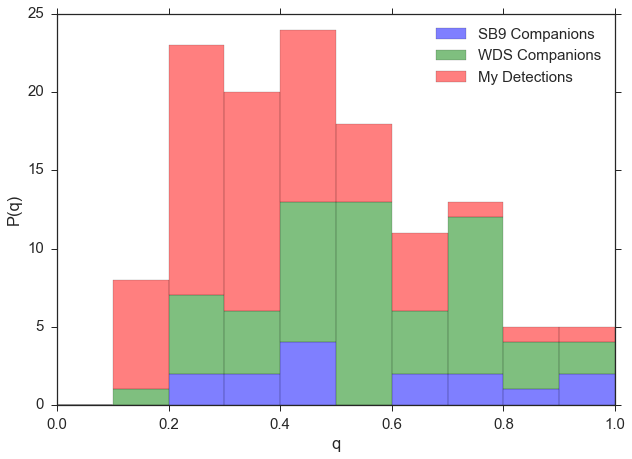

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))
bins = np.arange(0, 1.1, 0.1)
low1, _, _ = ax.hist(all_companions.SB9_q.dropna().values, bins=bins, color='blue', alpha=0.5, label='SB9 Companions')
low2, _, _ = ax.hist(all_companions.WDS_q.dropna().values, bins=bins, bottom=low1, color='green', alpha=0.5, label='WDS Companions')
ax.hist(all_companions.q.dropna().values, bins=bins, bottom=low1+low2, color='red', alpha=0.5, label='My Detections')

#qplot = np.arange(0.1, 1.01, 0.01)
#N = 50
#gamma = 0.8
#plt.plot(qplot, N*(1-gamma)*qplot**(-gamma))

leg = ax.legend(loc='best', fancybox=True)
ax.set_xlabel('q')
ax.set_ylabel('P(q)')
plt.savefig('Figures/CombinedMassRatios.pdf')

In [47]:
qplot

NameError: name 'qplot' is not defined